# BiasedMF

In [1]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import GridSearchCV 
from surprise.model_selection import train_test_split
import matplotlib.pyplot as plt

C:\Users\user\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\user\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


## Load Data

In [2]:
data = pd.read_csv("data/Tempat-Wisata-Toba-Preprocessing.csv")

In [3]:
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'address', 'PlaceID',
       'Nama_tempat_wisata', 'Category', 'ReviewerId', 'Rating', 'Reviews'],
      dtype='object')

In [4]:
data = data.rename(columns={'ReviewerId': 'user_id', 'PlaceID': 'item_id', 'Rating': 'rating'})
data['rating'] = data['rating'].astype(float)
data.dropna(inplace=True)
data.head()

,Unnamed: 0.1,Unnamed: 0,address,item_id,Nama_tempat_wisata,Category,user_id,rating,Reviews
1,1,1,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.119090e+20,5.0,bagus
3,3,3,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.130720e+20,5.0,sangat menyenagkan
4,4,4,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.061730e+20,5.0,bebas foto dimana aja cuma 2k
6,6,6,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.142390e+20,5.0,amazing pengen kesini lagi
8,8,8,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.047430e+20,3.0,jalan menuju lokasi perlu diperhatikan oleh pe...


In [5]:
col_to_drop = ['Unnamed: 0.1', 'Unnamed: 0', 'address', 'Category', 'Reviews']
data = data.drop(columns=col_to_drop)
data.head()

,item_id,Nama_tempat_wisata,user_id,rating
1,0,PASIR PUTIH LUMBAN BULBUL,1.119090e+20,5.0
3,0,PASIR PUTIH LUMBAN BULBUL,1.130720e+20,5.0
4,0,PASIR PUTIH LUMBAN BULBUL,1.061730e+20,5.0
6,0,PASIR PUTIH LUMBAN BULBUL,1.142390e+20,5.0
8,0,PASIR PUTIH LUMBAN BULBUL,1.047430e+20,3.0


In [6]:
data.shape

(22166, 4)

In [7]:
# Define Reader object
reader = Reader(rating_scale=(data['rating'].min(), data['rating'].max()))
dataset = Dataset.load_from_df(data[['user_id', 'item_id', 'rating']], reader)

## Split Data

In [10]:
from sklearn.model_selection import train_test_split

# Membagi data menjadi train (70%) dan sisanya (30%)
train_data, temp_data = train_test_split(data, test_size=0.30, random_state=42)

# Membagi temp_data menjadi validation (15% dari total data) dan test (15% dari total data)
val_data, test_data = train_test_split(temp_data, test_size=0.50, random_state=42)

# Menampilkan hasil pembagian data
print(f"Train data shape: {train_data.shape} ({len(train_data) / len(data):.2%} dari total data)")
print(f"Validation data shape: {val_data.shape} ({len(val_data) / len(data):.2%} dari total data)")
print(f"Test data shape: {test_data.shape} ({len(test_data) / len(data):.2%} dari total data)")

Train data shape: (15516, 4) (70.00% dari total data)
Validation data shape: (3325, 4) (15.00% dari total data)
Test data shape: (3325, 4) (15.00% dari total data)


## Create User-Item Matrix

In [12]:
# Create user-item matrix
def create_user_item_matrix(data, user_col='user_id', item_col='item_id', rating_col='rating'):
    data = data.groupby([user_col, item_col])[rating_col].mean().reset_index()
    return data.pivot(index=user_col, columns=item_col, values=rating_col).fillna(0)

# Generate matrices for each split
train_matrix = create_user_item_matrix(train_data)
val_matrix = create_user_item_matrix(val_data).reindex(columns=train_matrix.columns, fill_value=0)
test_matrix = create_user_item_matrix(test_data).reindex(columns=train_matrix.columns, fill_value=0)

# Print the matrices
print("Train Matrix:")
print(train_matrix)
print("\nValidation Matrix:")
print(val_matrix)
print("\nTest Matrix:")
print(test_matrix)

Train Matrix:
item_id       0    1    2    3    4    5    6    8    9    10   ...  92   93   \
user_id                                                         ...             
1.000030e+20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1.000040e+20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1.000090e+20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1.000100e+20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1.000120e+20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
...           ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1.184390e+20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  5.0  0.0   
1.184410e+20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1.184430e+20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  5.0   
1.184440e+20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1.184460e+20  

In [13]:
# Filter hanya user dengan minimal 10 interaksi
user_counts = data['user_id'].value_counts()
active_users = user_counts[user_counts >= 10].index
filtered_data = data[data['user_id'].isin(active_users)]

dataset = Dataset.load_from_df(filtered_data[['user_id', 'Nama_tempat_wisata', 'rating']], reader)

In [14]:
from surprise import SVD, SVDpp
from surprise.model_selection import GridSearchCV

# Definisikan parameter grid untuk hyperparameter tuning
param_grid = {
    'n_epochs': [20, 30, 50],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.2, 0.4, 0.6]
}

# GridSearchCV untuk SVD (Biased MF)
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
grid_search.fit(dataset)

# Tampilkan hasil grid search
print("Best parameters:", grid_search.best_params)
print("Best RMSE:", grid_search.best_score['rmse'])
print("Best MAE:", grid_search.best_score['mae'])

Best parameters: {'rmse': {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.4}, 'mae': {'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.2}}
Best RMSE: 0.7415714221783705
Best MAE: 0.5428731562567026


In [15]:
# Pilih model terbaik berdasarkan hasil grid search
best_model = grid_search.best_estimator['rmse']

# Latih model terbaik pada trainset
trainset = dataset.build_full_trainset()
best_model.fit(trainset)

# Evaluasi model pada testset
testset = trainset.build_testset()
predictions = best_model.test(testset)

In [18]:
# Hitung RMSE untuk evaluasi
rmse = accuracy.rmse(predictions)
print(f"RMSE: {rmse}")
mae = accuracy.mae(predictions)
print(f"RMSE: {mae}")

RMSE: 0.6075
RMSE: 0.6074579562240574
MAE:  0.4532
RMSE: 0.45320291169909627


In [17]:
from collections import defaultdict
from surprise import accuracy
import numpy as np

# Fungsi untuk menghitung Precision@K, Recall@K, dan MAP@K
def get_top_n(predictions, n=10):
    # Menyusun hasil prediksi menjadi dictionary dengan user_id sebagai kunci
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Urutkan dan ambil top-N untuk setiap user
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

# Fungsi untuk menghitung Precision@K dan Recall@K
def precision_recall_at_k(predictions, top_n, k=10):
    precision = 0
    recall = 0
    for uid, user_ratings in top_n.items():
        relevant_items = set([iid for iid, _ in user_ratings])
        recommended_items = set([iid for iid, _ in user_ratings[:k]])

        # Precision: jumlah item yang relevan di top-K / total item yang direkomendasikan
        precision += len(recommended_items.intersection(relevant_items)) / k

        # Recall: jumlah item yang relevan di top-K / total item relevan
        recall += len(recommended_items.intersection(relevant_items)) / len(relevant_items)

    # Rata-rata precision dan recall untuk semua user
    precision /= len(top_n)
    recall /= len(top_n)

    return precision, recall

# Fungsi untuk menghitung MAP@K
def mean_average_precision_at_k(predictions, top_n, k=10):
    mapk = 0
    for uid, user_ratings in top_n.items():
        relevant_items = set([iid for iid, _ in user_ratings])
        avg_precision = 0
        for i, (iid, _) in enumerate(user_ratings[:k]):
            if iid in relevant_items:
                avg_precision += len(relevant_items.intersection([iid])) / (i+1)

        # Rata-rata precision untuk satu user
        if len(relevant_items) > 0:
            avg_precision /= len(relevant_items)
        mapk += avg_precision

    # Rata-rata MAP untuk semua user
    mapk /= len(top_n)
    return mapk

# Prediksi testset
testset = trainset.build_testset()
predictions = best_model.test(testset)

# Ambil top-N rekomendasi
top_n = get_top_n(predictions, n=10)

# Hitung Precision@K, Recall@K, dan MAP@K untuk k=5 dan k=10
precision_5, recall_5 = precision_recall_at_k(predictions, top_n, k=5)
precision_10, recall_10 = precision_recall_at_k(predictions, top_n, k=10)
mapk_5 = mean_average_precision_at_k(predictions, top_n, k=5)
mapk_10 = mean_average_precision_at_k(predictions, top_n, k=10)

# Tampilkan hasil
print(f"Precision@5: {precision_5:.4f}")
print(f"Recall@5: {recall_5:.4f}")
print(f"MAP@5: {mapk_5:.4f}")

print(f"Precision@10: {precision_10:.4f}")
print(f"Recall@10: {recall_10:.4f}")
print(f"MAP@10: {mapk_10:.4f}")


Precision@5: 0.9782
Recall@5: 0.5137
MAP@5: 0.2403
Precision@10: 0.9564
Recall@10: 1.0000
MAP@10: 0.3082


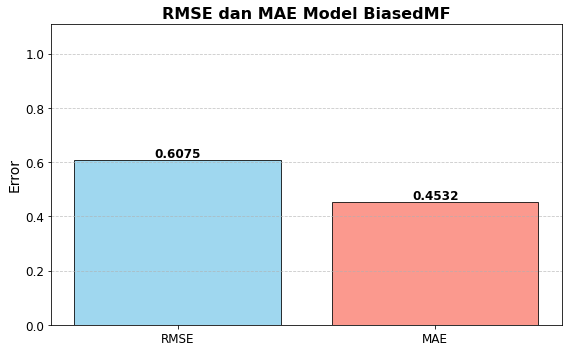

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Simpan nilai RMSE dan MAE yang sudah dihitung
metrics = {'RMSE': rmse, 'MAE': mae}

# Visualisasi menggunakan diagram batang
plt.figure(figsize=(8, 5))
plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'salmon'], alpha=0.8, edgecolor='black')

# Tambahkan nilai di atas batang
for i, (metric, value) in enumerate(metrics.items()):
    plt.text(i, value + 0.01, f'{value:.4f}', ha='center', fontsize=12, fontweight='bold')

# Tambahkan detail pada plot
plt.title('RMSE dan MAE Model BiasedMF', fontsize=16, fontweight='bold')
plt.ylabel('Error', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, max(metrics.values()) + 0.5)

# Tampilkan diagram batang
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

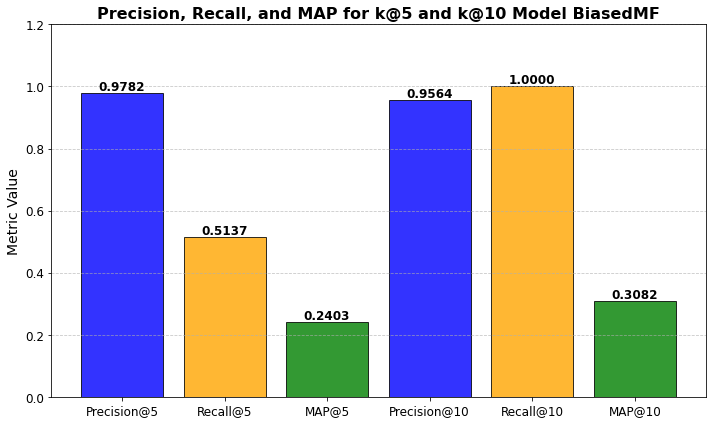

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Simpan nilai Precision, Recall, dan MAP untuk k@5 dan k@10
metrics = {
    'Precision@5': 0.9782,
    'Recall@5': 0.5137,
    'MAP@5': 0.2403,
    'Precision@10': 0.9564,
    'Recall@10': 1.0000,
    'MAP@10': 0.3082
}

# Visualisasi menggunakan diagram batang
plt.figure(figsize=(10, 6))
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'orange', 'green', 'blue', 'orange', 'green'], alpha=0.8, edgecolor='black')

# Tambahkan nilai di atas batang
for i, (metric, value) in enumerate(metrics.items()):
    plt.text(i, value + 0.01, f'{value:.4f}', ha='center', fontsize=12, fontweight='bold')

# Tambahkan detail pada plot
plt.title('Precision, Recall, and MAP for k@5 and k@10 Model BiasedMF', fontsize=16, fontweight='bold')
plt.ylabel('Metric Value', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, max(metrics.values()) + 0.2)

# Tampilkan diagram batang
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [32]:
algo = SVD()
algo.fit(trainset)

def get_top_n_recommendations(predictions, n=5):
    top_n = {}
    for uid, iid, true_r, est, _ in predictions:
        if uid not in top_n:
            top_n[uid] = []
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)

    top_n = {uid: user_ratings[:n] for uid, user_ratings in top_n.items()}
    
    return top_n

user_id = '1.08733e+20' 

unrated_items = data[~data['item_id'].isin(data[data['user_id'] == user_id]['item_id'])]
testset = [(user_id, iid, 4.) for iid in unrated_items['item_id'].unique()]

predictions = algo.test(testset)

top_n_recommendations = get_top_n_recommendations(predictions, n=5)

user_recommendations = top_n_recommendations.get(user_id, [])
if user_recommendations:
    print(f"Top 5 rekomendasi untuk User {user_id}: Model BiasedMF")
    recommendations_df = []
    for place_id, predicted_rating in user_recommendations:
        place_name = data[data['item_id'] == place_id]['Nama_tempat_wisata'].values[0]
        recommendations_df.append([place_id, place_name, predicted_rating])
    
    recommendations_df = pd.DataFrame(recommendations_df, columns=["Place ID", "Nama Tempat Wisata", "Predicted Rating"])
    print(recommendations_df)
else:
    print(f"Tidak ada rekomendasi untuk user {user_id}.")

Top 5 rekomendasi untuk User 1.08733e+20: Model BiasedMF
   Place ID                               Nama Tempat Wisata  Predicted Rating
0         0                        PASIR PUTIH LUMBAN BULBUL          4.505797
1         1  Patung Yesus, Bukit Sibea-bea, Huta Harian Boho          4.505797
2         2                      Pelabuhan wisata danau toba          4.505797
3         3                                        Singgolom          4.505797
4         4                        Puncak Panorama Aek Nauli          4.505797
